# Import packages

In [14]:
from array import array
import itertools
import time
import math

import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting.style import get_style, set_style
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import matplotlib.pyplot as plt
import numpy as np

import astroML.plotting as aml
import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from matplotlib.ticker import NullFormatter


# Define Bins

In [15]:
#FIXME: Read from Corr_config.yaml
zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
pTbins = [10, 11, 12.5, 16]

# Plot Titles

In [16]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    histo.SetTitle("#gamma-hadron: p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
                   %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    histo.GetXaxis().SetTitle("#Delta#phi")
    histo.GetYaxis().SetTitle("#frac{1}{N_{trig}} #frac{d^{2}N}{d#phid#eta}")
    histo.GetYaxis().SetTitleOffset(1)
    if not(DNN_Bool):
        histo.SetLineColor(2)

# Plot Triggers

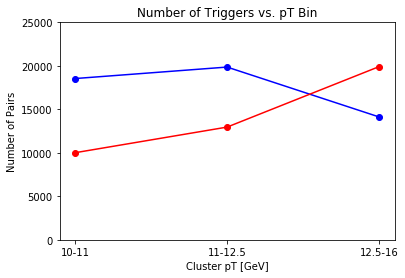

In [17]:
file = ROOT.TFile("Same_Mix_Ratio.root")
N_HighDNN_Triggers = []
N_LowDNN_Triggers = []
pT_Bins = ["10-11","11-12.5","12.5-16"]

for ipt in range(3):
    HighDNN = file.Get('N_DNN1_Triggers_pT%1.0f_%1.0f'%(pTbins[ipt],pTbins[ipt+1]))
    LowDNN = file.Get('N_DNN2_Triggers_pT%1.0f_%1.0f'%(pTbins[ipt],pTbins[ipt+1]))
    N_HighDNN_Triggers.append(HighDNN.GetEntries())
    N_LowDNN_Triggers.append(LowDNN.GetEntries())

y_pos = np.arange(len(pT_Bins))
plt.plot(pT_Bins, N_HighDNN_Triggers,'bo-',pT_Bins, N_LowDNN_Triggers, 'ro-')
plt.xticks(y_pos, pT_Bins)
plt.ylim([0,25000])
plt.ylabel('Number of Pairs')
plt.xlabel('Cluster pT [GeV]')
plt.title('Number of Triggers vs. pT Bin')

#plt.legend('HighDNN', 'LowDNN')
plt.savefig("pics/N_Triggers.png",dpi=200)
plt.show()

# Phi Projection & ZYAM

In [28]:
def GetPhiProj(filename, ipt, izt, Signal_DNN=True, doZYAM=True):
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))

    Eta_Axis = histo2D.GetYaxis()
    PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6));
    PhiProjection.SetDirectory(0)
    PhiProjection.Scale(1.0/1.2) #scale by eta region
    ntriggers = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    #PhiProjection.Scale(1.0/ntriggers.GetEntries()) #per trigger yield
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)
    
    zyam = PhiProjection.Integral(11,13)/3
    # how do I plot ZYAM, perhaps in both cases?
    #print('ZYAM=%f'%(zyam))
    if(doZYAM):
        for i in range(25):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error) 
    file.Close()
    return PhiProjection

# Plot Number of Pairs

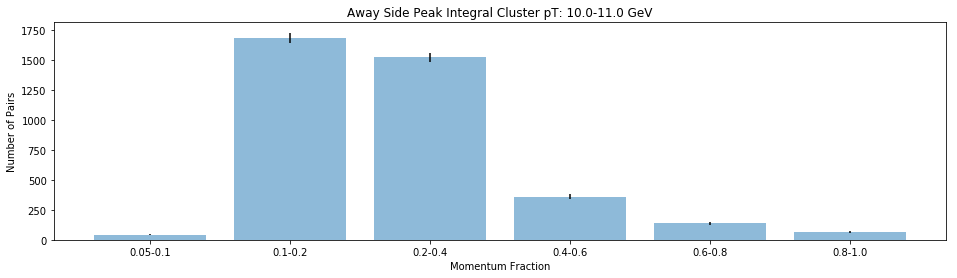

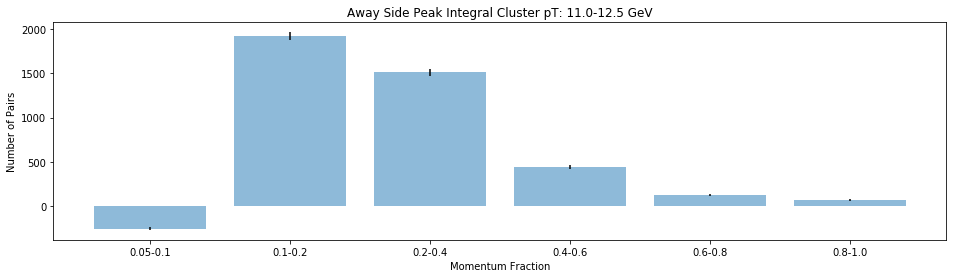

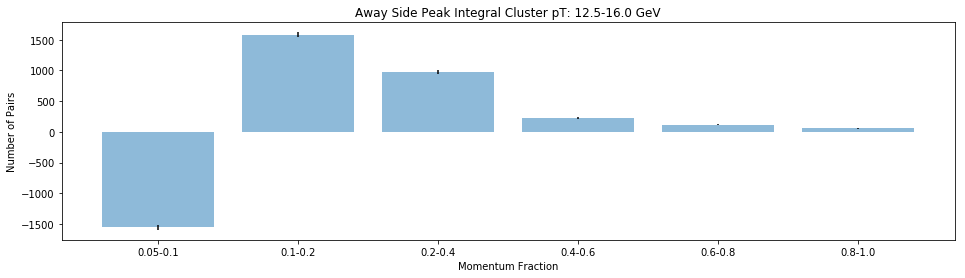

In [29]:
zT_Bins = ["0.05-0.1","0.1-0.2","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1.0"]

for ipt in range(3):
    N_pairs = []
    N_error = []
    for izt in range(6):
        Sig = GetPhiProj('Same_Mix_Ratio.root',ipt,izt,True,True)
        N_intgrl = Sig.Integral(14,24)
        N_pairs.append(N_intgrl)
        N_error.append(math.sqrt(abs(N_intgrl)))
    y_pos = np.arange(len(N_pairs))    
    plt.figure(figsize=(16,4))
    plt.bar(y_pos, N_pairs, align='center', alpha=0.5, yerr=N_error)
    plt.xticks(y_pos, zT_Bins)
    plt.ylabel('Number of Pairs')
    plt.xlabel('Momentum Fraction')
    plt.title('Away Side Peak Integral Cluster pT: %1.1f-%1.1f GeV'%(pTbins[ipt],pTbins[ipt+1]))
    plt.savefig("pics/N_Pairs_pT_%1.0f-%1.0f.png"%(pTbins[ipt],pTbins[ipt+1]),dpi=200)
    plt.show()    

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>
    
<sup>**NOTE**: SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

#### Plot Signal & Background

In [7]:
canv = ROOT.TCanvas("canv","canv",900,300)
canv.Divide(2)
Sig = GetPhiProj('Same_Mix_Ratio.root',1,3,True,True)#equal to returned plot
canv.cd(1)

Sig.Draw()
bkgd = GetPhiProj('Same_Mix_Ratio.root',1,3,False,True)
canv.cd(2)
bkgd.SetLineColor(2)
bkgd.Draw()
ROOT.enableJSVis()
canv.Draw()

# Low DNN Subtraction

In [8]:
def GetBKGsubtracted(filename, ptbin, ztbin, doZYAM=True, doSubtraction=True):
    Signal = GetPhiProj(filename,ptbin,ztbin,True,doZYAM)
    Background = GetPhiProj(filename,ptbin,ztbin,False,doZYAM)
    #purity = GetBinContent(ptbin)
    purity = 0.4
    Background.Scale(purity)
    if (doSubtraction):
        Signal.Add(Background,-1)
        #Root handles errors correctly. Have checked with manual quadrature sum
    return Signal,Background

### Check

In [9]:
c = ROOT.TCanvas("c","c",800,300)
ROOT.enableJSVis()
hsig,hbkd = GetBKGsubtracted('Same_Mix_Ratio.root',1,3,True)
hsig.Draw()
c.Draw()
#ROOT.disableJSVis()

# Loop and Plot

In [10]:
def Looping(filename,DoZYAM,DoSub=True):
    for ptbin in range(3):
        canvas = ROOT.TCanvas("canv%i"%(ptbin),"canv",2500,2000)
        canvas.Divide(2,3)
        for ztbin in range(6):
            hsig,hbkg = GetBKGsubtracted(filename,ptbin,ztbin,DoZYAM,DoSub)#doZYAM,doSubtraction
            canvas.cd(ztbin+1) 
            
            #set range
            ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
            hsig.GetYaxis().SetRangeUser(0,ymax)
            hbkg.GetYaxis().SetRangeUser(0,ymax)
            
            #plot Signal
            #Plot1D(hsig,ptbin,ztbin,True)
            hsig.Draw()
            
            #Overlay
            if not(DoSub): 
                #Plot1D(hbkg,ptbin,ztbin,False)
                hbkg.Draw("same")
                canvas.Update()
                canvas.Draw()
                
        if (DoSub): canvas.SaveAs('pics/correlations_Subtracted_ptbin%i.png'%(ptbin))
        else: canvas.SaveAs('pics/correlations_Overlay_ptbin%i.png'%(ptbin))

In [11]:
Looping('Same_Mix_Ratio.root',False,True)#Filename,DoZYAM,DoSub

INFO:ROOT.TCanvas.Print] png file pics/correlations_Subtracted_ptbin0.png has been created
INFO:ROOT.TCanvas.Print] png file pics/correlations_Subtracted_ptbin1.png has been created
INFO:ROOT.TCanvas.Print] png file pics/correlations_Subtracted_ptbin2.png has been created
